Epoch 0, Loss: 22.1002
Epoch 20, Loss: 0.0137
Epoch 40, Loss: 0.0005
Epoch 60, Loss: 0.0000
Epoch 80, Loss: 0.0000
Total possible covariance entries across all layers: 225
Initial diagonal entries: 27
Computing optimal ordering (this may take a while)...
Computing optimal ordering using forward simulation...
  Step 10: Added (2, 0, 9), KL = 0.388235
  Step 20: Added (3, 4, 5), KL = 0.120831
  Step 30: Added (1, 1, 0), KL = 0.028642
  Step 40: Added (1, 5, 1), KL = 0.009860
  Step 50: Added (3, 1, 3), KL = 0.002042
  Step 60: Added (1, 3, 1), KL = -0.000000
  Step 70: Added (2, 3, 7), KL = -0.000000
  Step 80: Added (2, 2, 11), KL = -0.000000
  Step 90: Added (2, 10, 1), KL = -0.000000
  Step 100: Added (2, 10, 3), KL = -0.000000
  Step 110: Added (2, 11, 1), KL = 0.000001
  Step 120: Added (2, 6, 11), KL = 0.000014
  Step 130: Added (2, 10, 4), KL = 0.000000
  Step 140: Added (2, 10, 6), KL = 0.000037
  Step 150: Added (2, 6, 8), KL = 0.000027
  Step 160: Added (2, 9, 2), KL = 0.000228

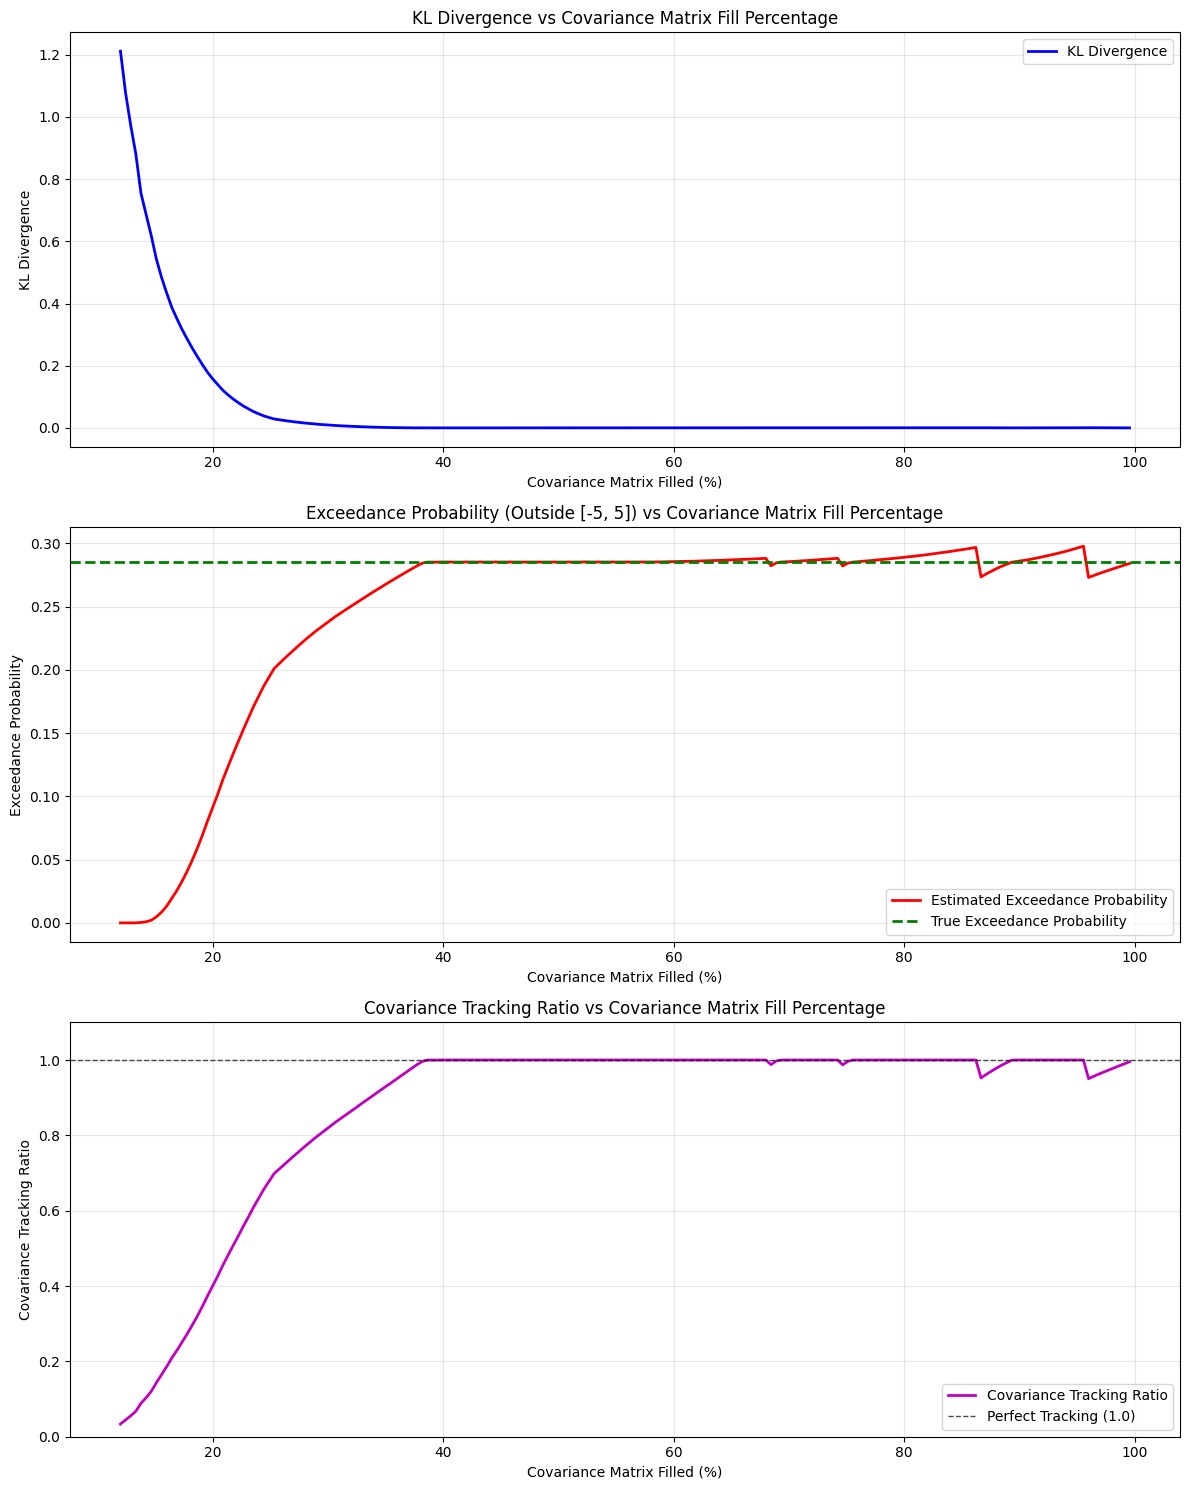


Final Results:
Final Percentage Filled: 99.56%
Final KL Divergence: 0.000005
Final Estimated Exceedance Probability: 0.284209
True Exceedance Probability: 0.285325
Difference in Exceedance Probabilities: 0.001116
Final Covariance Tracking Ratio: 0.995377


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.sparse import csc_matrix
from sksparse.cholmod import cholesky
import random
import os
from scipy.stats import norm
from torch.distributions import MultivariateNormal
import matplotlib.pyplot as plt

# Create output directory
os.makedirs('training_visualizations', exist_ok=True)

class DeepLinearNet(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DeepLinearNet, self).__init__()
        layers = []
        
        # Input to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        
        # Last hidden to output
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        self.layers = nn.ModuleList(layers)
    
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class SparseGaussian:
    def __init__(self, mean, covariance_sparse):
        self.mean = mean.cpu().numpy()
        self.covariance_sparse = covariance_sparse
        self.factor = cholesky(covariance_sparse)

def create_diagonal_mask(layer):
    input_dim = layer.weight.shape[1]
    mask = []
    for i in range(input_dim):
        mask.append((i, i))
    return mask

def update_mask(mask, dimension):
    n = dimension
    if len(mask) >= n * n:
        return mask
    while True:
        i, j = random.randint(0, n-1), random.randint(0, n-1)
        if (i, j) not in mask:
            mask.append((i, j))
            break
    return mask

def propagate_gaussian_analytically(input_mean, input_covariance_sparse, layer, mask=None):
    W = layer.weight.detach().cpu().numpy()  # Shape: (output_dim, input_dim)
    b = layer.bias.detach().cpu().numpy()
    mu_in_np = input_mean.detach().cpu().numpy()
    W_sparse = csc_matrix(W)
    # Mean propagation: μ_out = W * μ_in + b
    output_mean_np = W_sparse @ mu_in_np + b
    # Only keep the entries specified in the mask
    rows, cols, data = [], [], []
    for i, j in mask:
        rows.append(i)
        cols.append(j)
        data.append(input_covariance_sparse[i, j])
    
    # Reconstruct sparse matrix with only masked entries
    masked_covariance = csc_matrix((data, (rows, cols)), shape=input_covariance_sparse.shape)
    # Covariance propagation with masked matrix: Σ_out = W * Σ_masked * W^T
    temp = masked_covariance @ W_sparse.T  # Σ_masked * W^T
    output_covariance_sparse = W_sparse @ temp   # W * (Σ_masked * W^T)
    output_mean = torch.from_numpy(output_mean_np).float()
    return output_mean, output_covariance_sparse

def compute_estimator_mse(true_output_distribution, predicted_output_distribution):
    true_mean = torch.tensor(true_output_distribution.mean)
    predicted_mean = torch.tensor(predicted_output_distribution.mean)
    mse = torch.mean((true_mean - predicted_mean) ** 2)
    return mse.item()

def compute_estimator_kl_div(true_output_distribution, predicted_output_distribution):
    mu_true = true_output_distribution.mean
    mu_pred = predicted_output_distribution.mean
    sigma_true = true_output_distribution.covariance_sparse.toarray()
    sigma_pred = predicted_output_distribution.covariance_sparse.toarray()
    # Compute mean difference
    mu_diff = mu_pred - mu_true
    # Compute KL divergence: KL(P||Q) = 0.5 * [tr(Σ_Q^(-1) * Σ_P) + (μ_Q - μ_P)^T * Σ_Q^(-1) * (μ_Q - μ_P) - k + ln(det(Σ_Q)/det(Σ_P))]
    k = len(mu_true)
    sigma_true_inv = np.linalg.inv(sigma_true)
    trace_term = np.trace(sigma_true_inv @ sigma_pred)
    quad_term = mu_diff.T @ sigma_true_inv @ mu_diff
    log_det_term = np.log(np.linalg.det(sigma_true)) - np.log(np.linalg.det(sigma_pred))
    kl_div = 0.5 * (trace_term + quad_term - k + log_det_term)
    return kl_div

def find_true_distribution(input_distribution, model):
    # Start with the input distribution parameters
    current_mean = input_distribution.mean.cpu().numpy()
    current_covariance = input_distribution.covariance_matrix.cpu().numpy()
    
    # Propagate through each layer of the model
    with torch.no_grad():
        for layer in model.layers:
            W = layer.weight.detach().cpu().numpy()
            b = layer.bias.detach().cpu().numpy()
            
            # Transform mean: μ_out = W * μ_in + b
            current_mean = W @ current_mean + b
            
            # Transform covariance: Σ_out = W * Σ_in * W^T
            current_covariance = W @ current_covariance @ W.T
    
    # Convert final covariance to sparse format and create SparseGaussian
    current_covariance_sparse = csc_matrix(current_covariance)
    current_mean_tensor = torch.from_numpy(current_mean).float()
    
    true_output_distribution = SparseGaussian(current_mean_tensor, current_covariance_sparse)
    return true_output_distribution

def calculate_range_exceedance_probability(sparse_gaussian_dist, lower_bound=-5, upper_bound=5):
    mean = sparse_gaussian_dist.mean
    mu = mean[0] if len(mean.shape) > 0 else mean
    variance = sparse_gaussian_dist.covariance_sparse[0, 0]
    sigma = np.sqrt(max(variance, 1e-9))
    prob_below = norm.cdf(lower_bound, loc=mu, scale=sigma)
    prob_above = 1 - norm.cdf(upper_bound, loc=mu, scale=sigma)
    return prob_below + prob_above

def calculate_covariance_tracking_ratio(true_distribution, estimated_distribution):
    true_covariance_sparse = true_distribution.covariance_sparse
    estimated_covariance_sparse = estimated_distribution.covariance_sparse
    
    true_norm = np.sqrt((true_covariance_sparse.multiply(true_covariance_sparse)).sum())
    estimated_norm = np.sqrt((estimated_covariance_sparse.multiply(estimated_covariance_sparse)).sum())
    
    if true_norm == 0:
        return 1.0 if estimated_norm == 0 else 0.0
    
    return min(estimated_norm / true_norm, 1.0)

def calculate_total_covariance_entries(model, input_dim):
    total_entries = 0
    current_dim = input_dim
    for layer in model.layers:
        total_entries += current_dim * current_dim
        current_dim = layer.weight.shape[0]
    return total_entries

def calculate_initial_entries(model, input_dim):
    initial_entries = 0
    current_dim = input_dim
    
    for layer in model.layers:
        # Each layer starts with diagonal entries
        initial_entries += current_dim
        # Update dimension for next layer
        current_dim = layer.weight.shape[0]
    
    return initial_entries

def create_perfect_ordering(input_distribution, model, initial_masks):
    print("Computing optimal ordering using forward simulation...")
    true_output_distribution = find_true_distribution(input_distribution, model)
    current_masks = [mask.copy() for mask in initial_masks]
    optimal_ordering = []
    initial_mean = input_distribution.mean
    initial_covariance = csc_matrix(input_distribution.covariance_matrix.numpy())
    max_iterations = 2000  # Prevent infinite loop
    iteration = 0
    while iteration < max_iterations:
        best_kl_divergence = float('inf')
        best_choice = None
        
        # For each layer, try adding each possible new entry
        for layer_idx, layer in enumerate(model.layers):
            current_mask = current_masks[layer_idx]
            
            # Determine the dimension we're working with at this layer
            if layer_idx == 0:
                dimension = initial_covariance.shape[0]
            else:
                # Need to trace through previous layers to get current dimension
                temp_mean = initial_mean
                temp_covariance = initial_covariance
                for prev_layer_idx in range(layer_idx):
                    prev_layer = model.layers[prev_layer_idx]
                    temp_mean, temp_covariance = propagate_gaussian_analytically(
                        temp_mean, temp_covariance, prev_layer, current_masks[prev_layer_idx]
                    )
                dimension = temp_covariance.shape[0]
            
            # Try adding each possible new entry to this layer's mask
            for i in range(dimension):
                for j in range(dimension):
                    if (i, j) not in current_mask:
                        # Create temporary masks with this entry added
                        temp_masks = [mask.copy() for mask in current_masks]
                        temp_masks[layer_idx].append((i, j))
                        # Simulate forward propagation with these masks
                        try:
                            temp_mean = initial_mean
                            temp_covariance = initial_covariance
                            
                            for temp_layer_idx, temp_layer in enumerate(model.layers):
                                temp_mean, temp_covariance = propagate_gaussian_analytically(
                                    temp_mean, temp_covariance, temp_layer, temp_masks[temp_layer_idx]
                                )
                            # Check if this is the best choice so far
                            estimated_output_distribution = SparseGaussian(temp_mean, temp_covariance)
                            kl_divergence = compute_estimator_kl_div(true_output_distribution, estimated_output_distribution)
                            if kl_divergence < best_kl_divergence:
                                best_kl_divergence = kl_divergence
                                best_choice = (layer_idx, i, j)      
                        except Exception as e:
                            print(f"Skipping choice ({layer_idx}, {i}, {j}) due to error: {e}")
                            continue
        
        # If we found a good choice, add it to the ordering and update masks
        if best_choice is not None:
            layer_idx, i, j = best_choice
            optimal_ordering.append(best_choice)
            current_masks[layer_idx].append((i, j))
            if len(optimal_ordering) % 10 == 0:
                print(f"  Step {len(optimal_ordering)}: Added ({layer_idx}, {i}, {j}), KL = {best_kl_divergence:.6f}")
        else:
            print(f"No more beneficial entries found after {len(optimal_ordering)} additions")
            break

        iteration += 1
    print(f"Optimal ordering computed: {len(optimal_ordering)} entries")
    return optimal_ordering

def update_mask_with_ordering(masks, ordering, step):
    if step < len(ordering):
        layer_idx, i, j = ordering[step]
        if (i, j) not in masks[layer_idx]:
            masks[layer_idx].append((i, j))
    
    return masks

torch.manual_seed(42)
input_mean = torch.zeros(3)
full_covariance_matrix = torch.tensor([
    [1.0, 0.7, 0.3],
    [0.7, 1.5, 0.8],
    [0.3, 0.8, 2.0]
])
input_distribution = MultivariateNormal(loc=input_mean, covariance_matrix=full_covariance_matrix)
X = input_distribution.sample(torch.Size([1000]))
true_weights = torch.tensor([[2.0], [3.0], [-1.0]])
y = X @ true_weights

# --- Model Training ---
model = DeepLinearNet(input_size=3, hidden_sizes=[6, 12, 6], output_size=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')



# --- Main Propagation Loop with Perfect Ordering ---
input_dim = 3 
total_entries = calculate_total_covariance_entries(model, input_dim)
initial_entries = calculate_initial_entries(model, input_dim)
print(f"Total possible covariance entries across all layers: {total_entries}")
print(f"Initial diagonal entries: {initial_entries}")

initial_mean = input_distribution.mean
initial_covariance = csc_matrix(input_distribution.covariance_matrix.numpy())
training_steps = 5000
masks = []
for layer in model.layers:
    masks.append(create_diagonal_mask(layer))
# PRE-COMPUTE THE OPTIMAL ORDERING
print("Computing optimal ordering (this may take a while)...")
optimal_ordering = create_perfect_ordering(input_distribution, model, masks)
print(f"Optimal ordering contains {len(optimal_ordering)} entries")
training_steps = min(training_steps, len(optimal_ordering))
print(f"Running {training_steps} training steps")
kl_divergences = []
estimated_exceedance_probs = []
covariance_tracking_ratios = []
percent_filled = [] 
true_output_distribution = find_true_distribution(input_distribution, model)
true_exceedance_prob = calculate_range_exceedance_probability(true_output_distribution)

with torch.no_grad():
    for step in range(training_steps):
        propagated_gaussians = []
        current_mean = initial_mean
        current_covariance = initial_covariance
        if step > 0:
            masks = update_mask_with_ordering(masks, optimal_ordering, step - 1)
        
        # Calculate current percentage filled
        current_entries = initial_entries + step
        current_percent = (current_entries / total_entries) * 100
        percent_filled.append(current_percent)
        for layer_idx, layer in enumerate(model.layers):
            output_mean, output_covariance = propagate_gaussian_analytically(current_mean, current_covariance, layer, masks[layer_idx])
            propagated_layer_gaussian = SparseGaussian(output_mean, output_covariance)
            propagated_gaussians.append(propagated_layer_gaussian)
            current_mean = output_mean
            current_covariance = output_covariance
        estimated_output_distribution = propagated_gaussians[-1]
        
        # Calculate metrics for this step
        estimator_mse = compute_estimator_mse(true_output_distribution, estimated_output_distribution)
        kl_divergence = compute_estimator_kl_div(true_output_distribution, estimated_output_distribution)
        estimated_exceedance_prob = calculate_range_exceedance_probability(estimated_output_distribution)
        covariance_tracking_ratio = calculate_covariance_tracking_ratio(true_output_distribution, estimated_output_distribution)
        kl_divergences.append(kl_divergence)
        estimated_exceedance_probs.append(estimated_exceedance_prob)
        covariance_tracking_ratios.append(covariance_tracking_ratio)
        if step % 100 == 0:
            next_addition = optimal_ordering[step] if step < len(optimal_ordering) else "None"
            print(f"Step {step}: {current_percent:.2f}% filled, KL Div = {kl_divergence:.6f}, Est. Exceedance = {estimated_exceedance_prob:.6f}/{true_exceedance_prob:.6f}, Cov. Ratio = {covariance_tracking_ratio:.6f}, Next: {next_addition}")

# --- Create Visualization ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
ax1.plot(percent_filled, kl_divergences, 'b-', linewidth=2, label='KL Divergence')
ax1.set_xlabel('Covariance Matrix Filled (%)')
ax1.set_ylabel('KL Divergence')
ax1.set_title('KL Divergence vs Covariance Matrix Fill Percentage')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax2.plot(percent_filled, estimated_exceedance_probs, 'r-', linewidth=2, label='Estimated Exceedance Probability')
ax2.axhline(y=true_exceedance_prob, color='g', linestyle='--', linewidth=2, label='True Exceedance Probability')
ax2.set_xlabel('Covariance Matrix Filled (%)')
ax2.set_ylabel('Exceedance Probability')
ax2.set_title('Exceedance Probability (Outside [-5, 5]) vs Covariance Matrix Fill Percentage')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax3.plot(percent_filled, covariance_tracking_ratios, 'm-', linewidth=2, label='Covariance Tracking Ratio')
ax3.axhline(y=1.0, color='k', linestyle='--', linewidth=1, alpha=0.7, label='Perfect Tracking (1.0)')
ax3.set_xlabel('Covariance Matrix Filled (%)')
ax3.set_ylabel('Covariance Tracking Ratio')
ax3.set_title('Covariance Tracking Ratio vs Covariance Matrix Fill Percentage')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_ylim(0, 1.1)
plt.tight_layout()
plt.savefig('training_visualizations/gaussian_propagation_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Output ---
print("\nFinal Results:")
print(f"Final Percentage Filled: {percent_filled[-1]:.2f}%")
print(f"Final KL Divergence: {kl_divergences[-1]:.6f}")
print(f"Final Estimated Exceedance Probability: {estimated_exceedance_probs[-1]:.6f}")
print(f"True Exceedance Probability: {true_exceedance_prob:.6f}")
print(f"Difference in Exceedance Probabilities: {abs(estimated_exceedance_probs[-1] - true_exceedance_prob):.6f}")
print(f"Final Covariance Tracking Ratio: {covariance_tracking_ratios[-1]:.6f}")